In [1]:
# import scipy.io
# import numpy as np
# import pandas as pd
import sys
import os

# # Go up two levels to reach the project root and add it to the path
sys.path.append(os.path.abspath("../"))

# from src.features.BearingData import BearingData
# from src.features.SignalProcessor import SignalProcessor

# # Example file path
# file_path = "../dataset/paderborn-db/K004/N09_M07_F10_K004_1.mat"

# # Create BearingData object
# bearing_data = BearingData(file_path)

# # # Access data
# # signals = bearing_data.signals

# # print(signals)

# # Usage Verification
# # data = BearingData('N09_M07_F10_K001_10.mat')
# # show all variables keys
# print(bearing_data.metadata)

# # signal_data = SignalProcessor(bearing_data.signals[''])

# # print(signal_data.get_all_features())

In [2]:
from src.loader.load_dataset import load_all_matfiles
df = load_all_matfiles()


df.head()



Processing ../dataset/paderborn-db: 0it [00:00, ?it/s]
Processing ../dataset/paderborn-db/KA08:  52%|█████▎    | 42/80 [00:02<00:02, 14.25it/s]

Error loading ../dataset/paderborn-db/KA08/N15_M01_F10_KA08_2.mat: Expecting matrix here


Processing ../dataset/paderborn-db/KI04: 100%|██████████| 80/80 [00:06<00:00, 12.15it/s]


,torque_nm,speed_rpm,radial_force_n,label,force_rms,force_kurtosis,force_skewness,force_crest_factor,force_peak_to_peak,force_std_dev,...,torque_skewness,torque_crest_factor,torque_peak_to_peak,torque_std_dev,vibration_1_rms,vibration_1_kurtosis,vibration_1_skewness,vibration_1_crest_factor,vibration_1_peak_to_peak,vibration_1_std_dev
0,0.7,1500,400,1,448.264415,-0.948663,0.032974,1.365302,340.270996,39.120142,...,0.003434,1.091256,0.228676,0.042464,0.518003,19.384970,1.903199,11.735645,10.336304,0.517786
1,0.7,900,1000,1,1059.677313,-1.054421,-0.134650,1.158136,344.848633,45.395342,...,-0.285999,1.086635,0.243706,0.039622,0.227813,12.999637,1.132015,11.413290,4.809570,0.227321
2,0.7,1500,400,1,445.769547,-0.874566,0.017596,1.367466,344.238281,38.896105,...,0.047220,1.108630,0.280754,0.049567,0.521671,19.586672,1.982920,10.863386,9.588623,0.521458
3,0.7,1500,400,1,445.278862,-0.937106,0.041063,1.360749,328.674316,38.698392,...,-0.010006,1.083829,0.209036,0.037930,0.520496,19.800676,1.984644,11.398000,9.835815,0.520280
4,0.7,1500,1000,1,1056.897847,-1.149167,-0.088065,1.162337,319.519043,45.129524,...,-0.217800,1.087675,0.243643,0.042981,0.540600,11.751166,0.698111,7.270924,7.778931,0.540341


In [3]:
# Show data distribution
df['label'].value_counts()

label
1    959
2    880
0    480
3    240
Name: count, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)


smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)



print(y_train.value_counts())
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

label
2    767
0    767
1    767
3    767
Name: count, dtype: int64
X_train shape: (3068, 45)
y_train shape: (3068,)
X_test shape: (512, 45)
y_test shape: (512,)


In [16]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        96
           1       1.00      0.92      0.96       192
           2       0.93      1.00      0.96       176
           3       1.00      1.00      1.00        48

    accuracy                           0.97       512
   macro avg       0.98      0.98      0.98       512
weighted avg       0.97      0.97      0.97       512



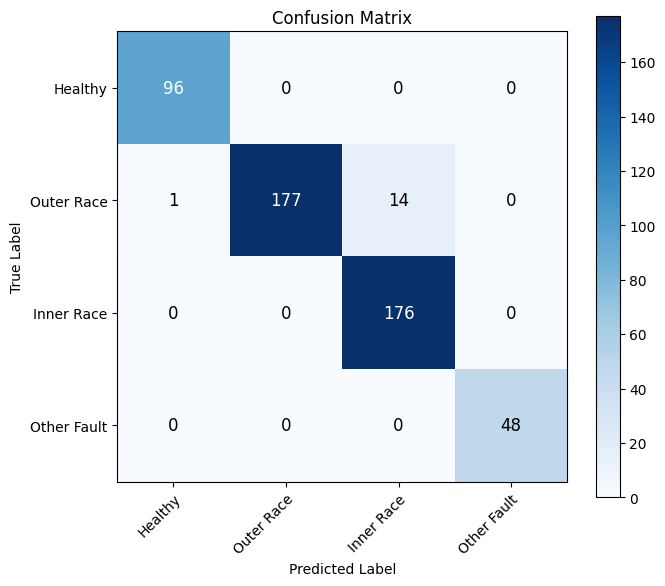

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Example: your predicted and true labels
# y_test, y_pred

# Define class names
class_names = ['Healthy', 'Outer Race', 'Inner Race', 'Other Fault']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set ticks and labels
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='True Label',
    xlabel='Predicted Label',
    title='Confusion Matrix'
)

# Rotate x-axis labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > thresh else "black"
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color=color, fontsize=12)

plt.tight_layout()
plt.show()


In [23]:
# confusion_matrix value
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 96,   0,   0,   0],
       [  1, 177,  14,   0],
       [  0,   0, 176,   0],
       [  0,   0,   0,  48]])